In [ ]:
import pennylane as qml
import torch

# We create our data and labels

x_train = torch.tensor([0.2, 0.1, 0.14])

# We define the circuit we are going to use

dev = qml.device("default.qubit", wires=1)


# @qml.qnode(dev, interface="torch")
def simple_qubit_circuit(theta, input_value):
    qml.RX(input_value, wires=0)
    qml.RY(theta, wires=0)
    return qml.expval(qml.PauliZ(0))


theta = 0.2
y = simple_qubit_circuit(theta, x_train)
print(x_train.shape)
print(y.shape)
print(y)

In [87]:
import torch

def find_grid_points(x, n):
    num_segments = 2 ** (n-1)
    segment_length = 2 / num_segments

    # Ensure x is a torch tensor
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float64)

    # Validate that x is in the range [-1, 1]
    if torch.any(x < -1) or torch.any(x > 1):
        raise ValueError("Input x must be in the range [-1, 1]")

    # Calculate the position for each x
    position = ((x + 1) / segment_length).floor()

    # Determine the grid points
    left_point = -1 + position * segment_length
    right_point = left_point + segment_length

    return left_point, right_point, position

# Example usage
x = torch.tensor([0.5, -0.3, 0.9])
n = 3
left_points, right_points, position = find_grid_points(x, n)
print("Left Points:", left_points)
print("Right Points:", right_points)
print("Position:", position)

Left Points: tensor([ 0.5000, -0.5000,  0.5000])
Right Points: tensor([1., 0., 1.])
Position: tensor([3., 1., 3.])


In [122]:
import torch

import torch

def sawtooth_vector(x, n):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float64)

    if torch.any(x < -1) or torch.any(x > 1):
        raise ValueError("Input x must be in the range [-1, 1]")

    num_elements = 2 ** n
    num_x = x.shape[0]
    vector = torch.zeros(num_x, num_elements, dtype=torch.float64)

    # Initialize the vector with the first two entries
    vector[:, 0] = torch.sqrt(0.5 * (1 + x))
    vector[:, 1] = torch.sqrt(0.5 * (1 - x))

    count = 2
    for k in range(1, 2**(n-1), 1):
        left_node, right_node, position = find_grid_points(x, k+1)

        sawtooth_up = (x - left_node) / (right_node - left_node)
        sawtooth_down = (right_node - x) / (right_node - left_node)
        sawtooth_up = torch.sqrt(sawtooth_up)
        sawtooth_down = torch.sqrt(sawtooth_down)

        for i in range(num_x):
            odd = position[i].long() % 2
            if not odd:
               vector[i, count] = sawtooth_up[i]
               vector[i, count+1] = sawtooth_down[i]
            else:
               vector[i, count] = sawtooth_down[i]
               vector[i, count+1] = sawtooth_up[i]
                
        count += 2

    return vector


# Example usage
x = torch.tensor([0.5])
n = 3
print(sawtooth_vector(x, n))
print(sawtooth_vector(x, n).shape)

tensor([[0.8660, 0.5000, 0.7071, 0.7071, 1.0000, 0.0000, 0.0000, 1.0000]],
       dtype=torch.float64)
torch.Size([1, 8])


In [35]:
import numpy as np
import torch

def linear_FEM_basis(x, n):
    num_nodes = 2 ** n
    nodes = np.linspace(-1, 1, num_nodes)
    nodes = torch.tensor(nodes, dtype=torch.float64)

    # Initialize the output tensor
    values = torch.zeros(x.shape[0], num_nodes, dtype=torch.float64)
    
    # Distance between nodes
    h = 2 / (num_nodes - 1)

    # Handle tensor input for x
    for i in range(1, num_nodes):
        mask = (nodes[i - 1] <= x) & (x <= nodes[i])
        values[mask, i - 1] = (nodes[i] - x[mask]) / h
        values[mask, i] = (x[mask] - nodes[i - 1]) / h

    #values = torch.sqrt(values)
    return values.squeeze(0)

# Example usage with tensor input
x_tensor = torch.tensor([0.0, 0.5], dtype=torch.float64)
n = 1
result = linear_FEM_basis(x_tensor, n)
print(result)
print(result.shape)

tensor([[0.5000, 0.5000],
        [0.2500, 0.7500]], dtype=torch.float64)
torch.Size([2, 2])


In [16]:
import torchtt as tntt
full_tensor = result.reshape(2, 2, 2)
tens_tt = tntt.TT(full_tensor)
print('TT cores', tens_tt.cores)
print('Mode size ', tens_tt.N)
print('TT rank ', tens_tt.R)

TT cores [tensor([[[0., 1.],
         [1., 0.]]], dtype=torch.float64), tensor([[[ 1.,  0.],
         [ 0.,  0.]],

        [[ 0.,  0.],
         [ 0., -1.]]], dtype=torch.float64), tensor([[[ 0.5000],
         [ 0.0000]],

        [[ 0.0000],
         [-0.5000]]], dtype=torch.float64)]
Mode size  [2, 2, 2]
TT rank  [1, 2, 2, 1]


In [5]:
# Reshape the tensor into a 2x2 matrix
matrix = result.reshape(2, 2)

# Perform QR decomposition
q, r = torch.linalg.qr(matrix)

# Print the outputs
print("Original Matrix:\n", matrix)
print("Q Matrix:\n", q)
print("R Matrix:\n", r)

Original Matrix:
 tensor([[0.0000, 0.5000],
        [0.5000, 0.0000]], dtype=torch.float64)
Q Matrix:
 tensor([[ 0., -1.],
        [-1.,  0.]], dtype=torch.float64)
R Matrix:
 tensor([[-0.5000,  0.0000],
        [ 0.0000, -0.5000]], dtype=torch.float64)


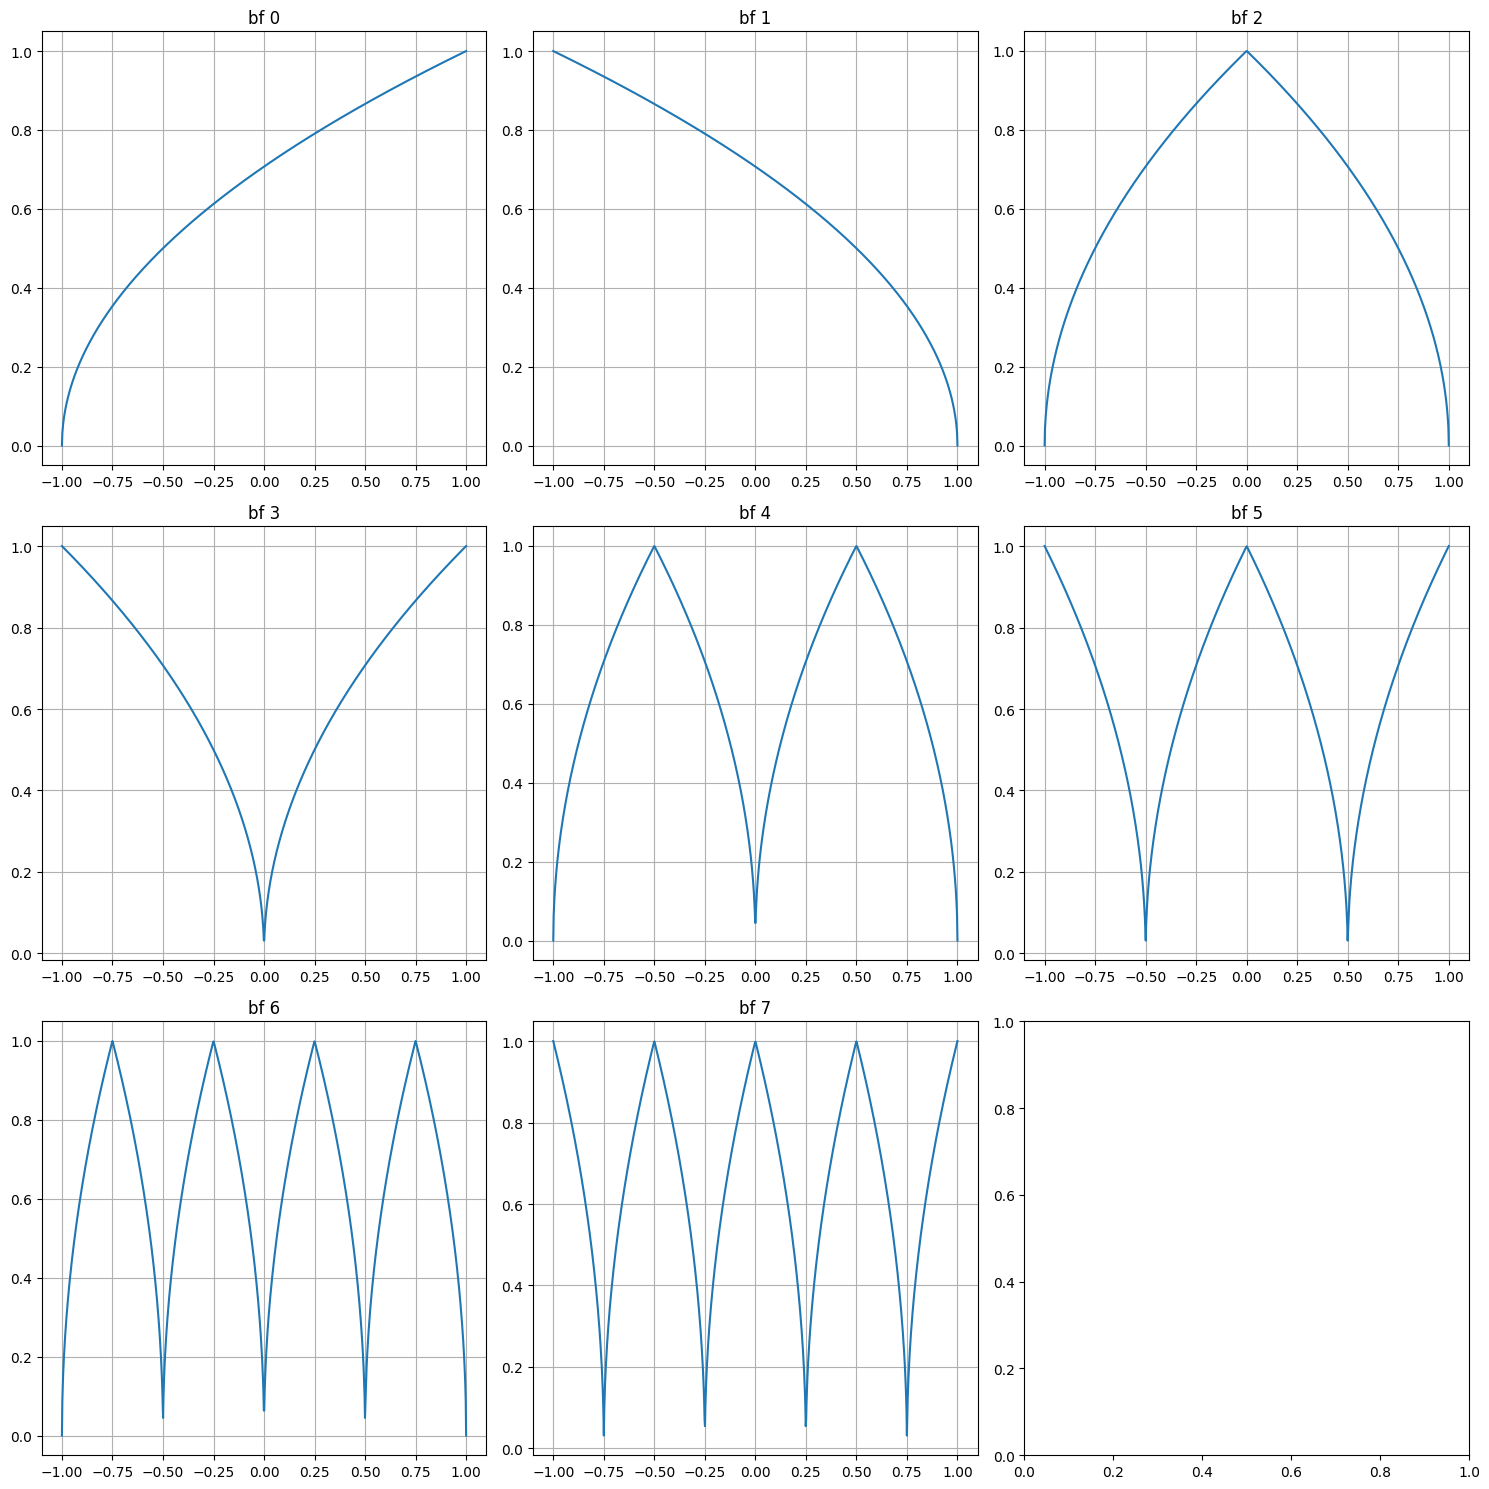

In [123]:
import matplotlib.pyplot as plt
import torch

def plot_basis_combinations(x_values, basis_functions, n):
    grid_size=(3, 3)
    num_plots = grid_size[0] * grid_size[1]
    _, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axs = axs.flatten()

    # Generate all unique combinations of basis functions
    for idx in range(basis_functions.shape[1]):
        axs[idx].plot(x_values, basis_functions[:, idx])
        axs[idx].set_title(f"bf {idx}")
        axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

# Generate x values for plotting
x_plot = torch.tensor(np.linspace(-1, 1, 1000))

# Generate the basis functions for each x in x_plot
basis_functions = linear_FEM_basis(x_plot, n)
basis_functions = sawtooth_vector(x_plot, n)
plot_basis_combinations(x_plot, basis_functions, n)

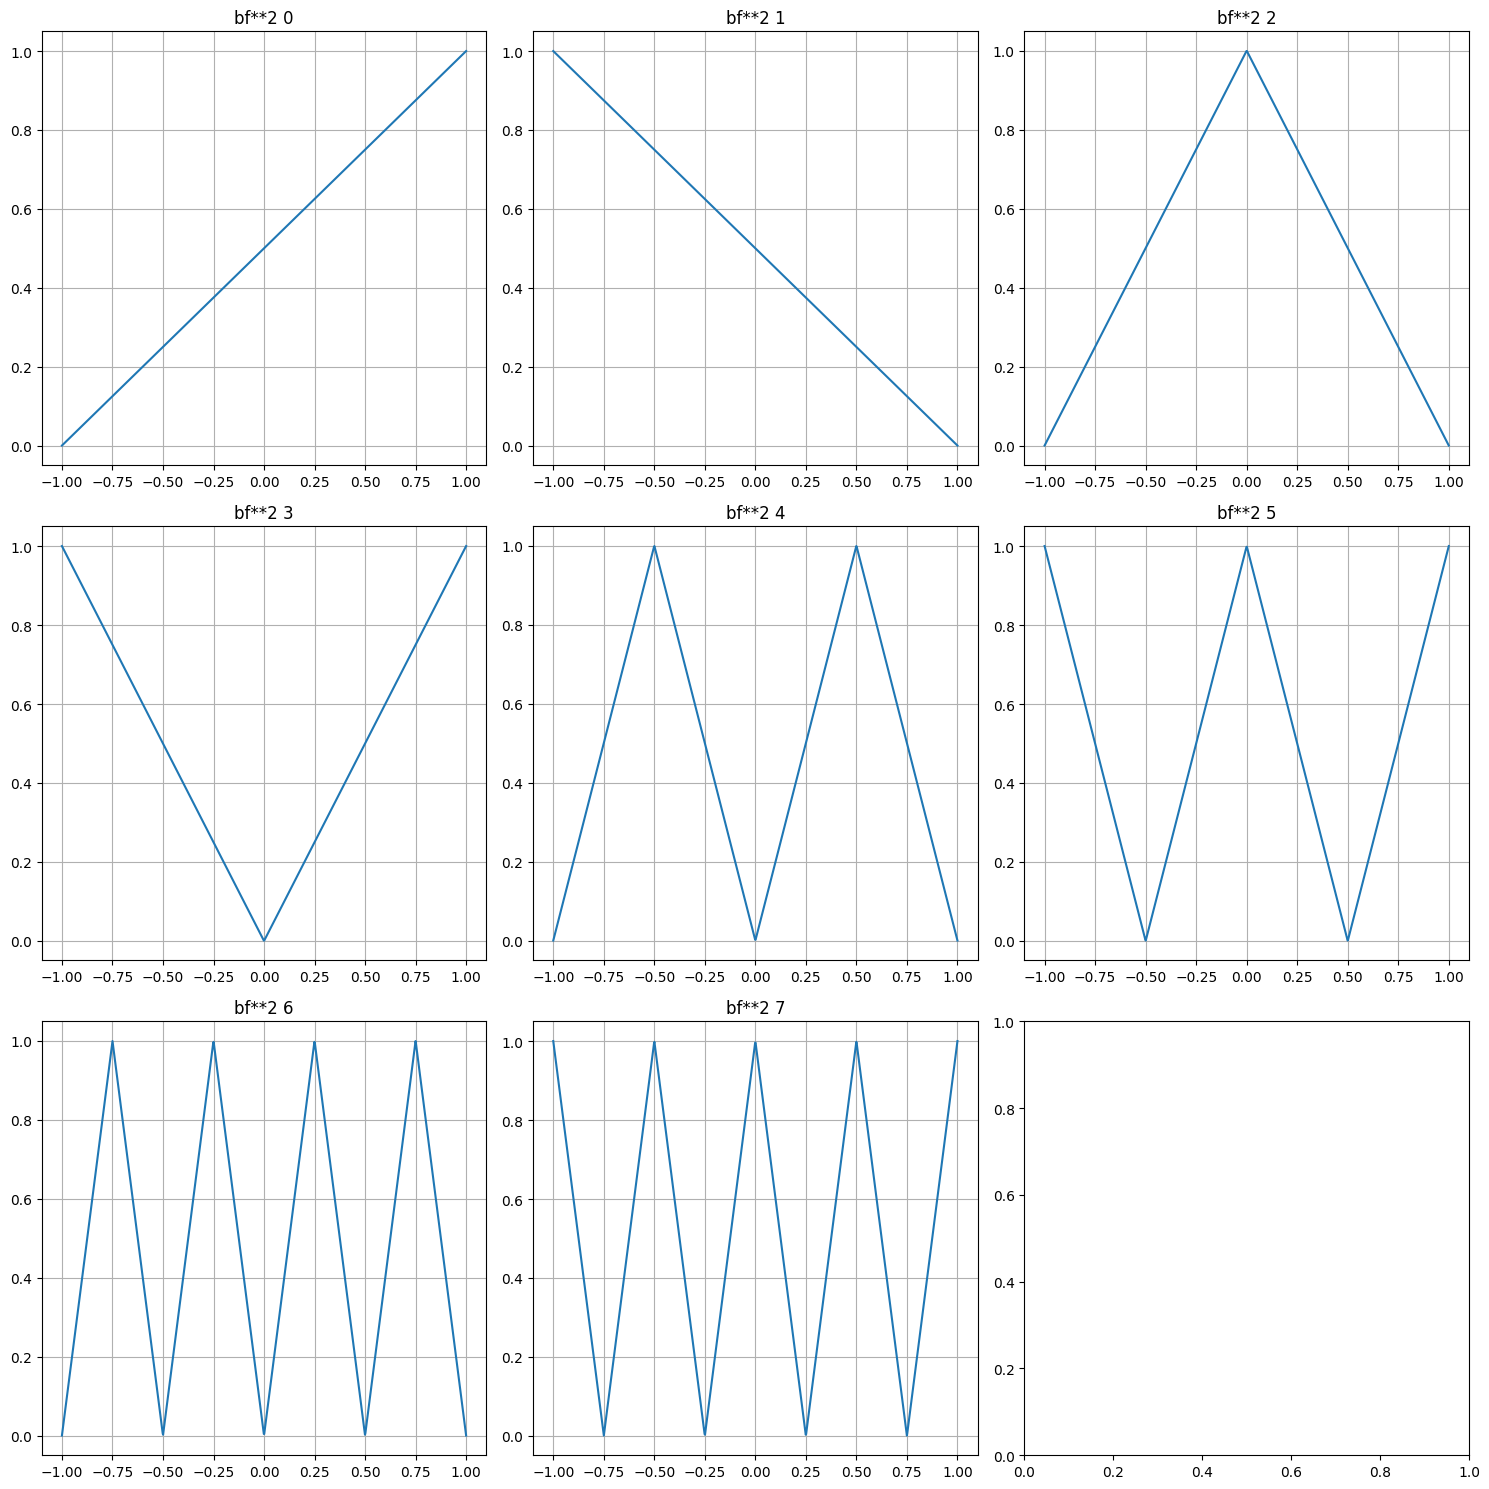

In [124]:
import matplotlib.pyplot as plt
import torch

def plot_basis_combinations(x_values, basis_functions, n):
    grid_size=(3, 3)
    num_plots = grid_size[0] * grid_size[1]
    _, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axs = axs.flatten()

    # Generate all unique combinations of basis functions
    for idx in range(basis_functions.shape[1]):
        bf = basis_functions[:, idx]
        axs[idx].plot(x_values, bf**2)
        axs[idx].set_title(f"bf**2 {idx}")
        axs[idx].grid(True)

    plt.tight_layout()
    plt.show()

# Generate x values for plotting
x_plot = torch.tensor(np.linspace(-1, 1, 1000))

# Generate the basis functions for each x in x_plot
basis_functions = linear_FEM_basis(x_plot, n)
basis_functions = sawtooth_vector(x_plot, n)
plot_basis_combinations(x_plot, basis_functions, n)

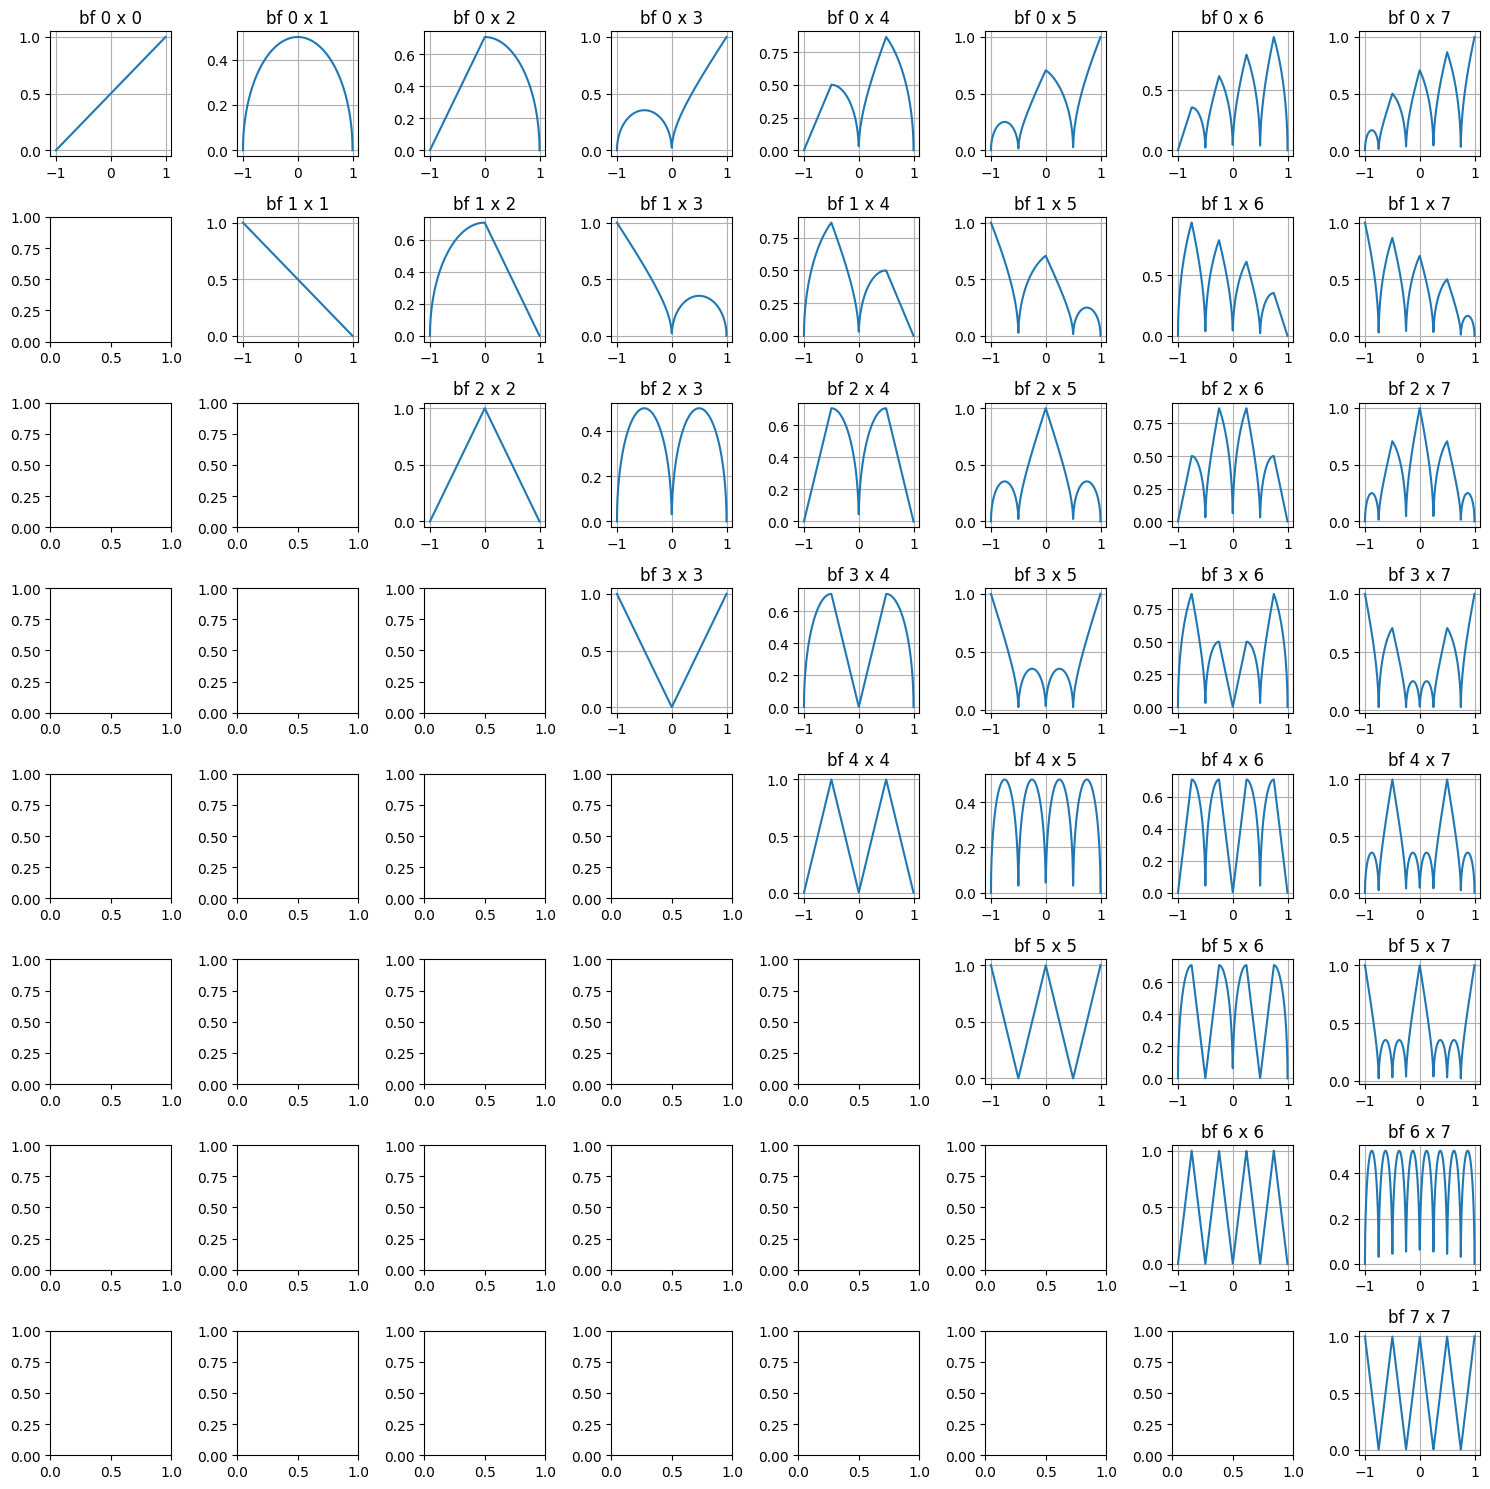

In [125]:
import matplotlib.pyplot as plt
import torch
import itertools

def plot_basis_combinations(x_values, basis_functions, n):
    s = 2**n
    grid_size=(s, s)
    num_plots = grid_size[0] * grid_size[1]
    _, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

    # Generate all unique combinations of basis functions
    all_combinations = list(itertools.combinations_with_replacement(range(2**n), 2))
    selected_combinations = all_combinations[:num_plots]

    for idx, (i, j) in enumerate(selected_combinations):
        combined_basis = basis_functions[:, i]*basis_functions[:, j]
        axs[i, j].plot(x_values, combined_basis)
        axs[i, j].set_title(f"bf {i} x {j}")
        axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

# Generate x values for plotting
x_plot = torch.tensor(np.linspace(-1, 1, 1000))

# Generate the basis functions for each x in x_plot
basis_functions = linear_FEM_basis(x_plot, n)
basis_functions = sawtooth_vector(x_plot, n)
plot_basis_combinations(x_plot, basis_functions, n)

In [128]:
import pennylane as qml

num_qubits = 3
dev = qml.device("default.qubit", wires=num_qubits)


@qml.qnode(dev)
def circuit(f=None):
    qml.AmplitudeEmbedding(features=f, wires=range(num_qubits), normalize=False)
    return qml.expval(qml.PauliZ(0))  # qml.state()


x = 0.3
f = linear_FEM_basis(x, num_qubits)
f = f / np.linalg.norm(f)
print(f)

AttributeError: 'float' object has no attribute 'shape'

In [152]:
import pennylane as qml
from qulearn import qlayer
import torch


class LinearAmplitudeEmbedding(qlayer.CircuitLayer):
    def __init__(self, num_qubits):
        super().__init__(num_qubits)
        self.num_qubits = num_qubits

    def circuit(self, x):
        Phi = linear_FEM_basis(x, self.num_qubits)
        #Phi = sawtooth_vector(x, self.num_qubits)
        Phi = Phi / torch.linalg.norm(Phi)
        qml.AmplitudeEmbedding(features=Phi, wires=self.wires, normalize=False)

In [153]:
num_qubits = 3
var0 = qlayer.AltRotCXLayer(wires=num_qubits, n_layers=3)

In [167]:
import pennylane as qml
from qulearn import qlayer
from torch import nn
import math

class AltRotCRXLayer(qlayer.CircuitLayer):
    def __init__(
        self,
        wires,
        n_layers = 1,
        cdevice = None,
        dtype = None,
    ) -> None:
        super().__init__(wires)

        self.n_layers = n_layers
        self.cdevice = cdevice
        self.dtype = dtype

        # weight parameters
        circ_offset = 1 if self.num_wires > 2 else 0
        
        self.initial_layer_weights = torch.nn.Parameter(
            torch.empty((self.num_wires, 3), device=self.cdevice, dtype=self.dtype)
        )
        
        self.one_qubit_weights = torch.nn.Parameter(
            torch.empty(
                (2*self.n_layers, 2 * (self.num_wires - 1) + 2*circ_offset, 3),
                device=self.cdevice,
                dtype=self.dtype,
            )
        )
        
        self.crx_weights = torch.nn.Parameter(
            torch.empty(
                (self.n_layers, self.num_wires - 1 + circ_offset),
                device=self.cdevice,
                dtype=self.dtype,
            )
        )
        self.xx_weights = torch.nn.Parameter(
            torch.empty(
                (self.n_layers, self.num_wires - 1 + circ_offset),
                device=self.cdevice,
                dtype=self.dtype,
            )
        )
       # nn.init.zeros_(self.initial_layer_weights)
       # nn.init.zeros_(self.one_qubit_weights)
       # nn.init.zeros_(self.two_qubit_weights)
       
        
        nn.init.uniform_(self.initial_layer_weights, a=0.0, b=2 * math.pi)
        nn.init.uniform_(self.one_qubit_weights, a=0.0, b=2 * math.pi)
        nn.init.uniform_(self.crx_weights, a=0.0, b=2 * math.pi)
        nn.init.uniform_(self.xx_weights, a=0.0, b=2 * math.pi)


    def circuit(self, _ = None):
       for index, q in enumerate(self.wires):
            qml.Rot(
                self.initial_layer_weights[index, 0],
                self.initial_layer_weights[index, 1],
                self.initial_layer_weights[index, 2],
                q,
            )

       for layer in range(self.n_layers):
           for i in range(0, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.CRX(self.crx_weights[layer, crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[layer, i, 0],
                   self.one_qubit_weights[layer, i, 1],
                   self.one_qubit_weights[layer, i, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[layer, i + 1, 0],
                   self.one_qubit_weights[layer, i + 1, 1],
                   self.one_qubit_weights[layer, i + 1, 2],
                   self.wires[i + 1],
               )

           offset_1q = (self.num_wires // 2) * 2
           offset_2q = self.num_wires//2
           for i in range(1, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.CRX(self.crx_weights[layer, offset_2q + crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[layer, offset_1q + i - 1, 0],
                   self.one_qubit_weights[layer, offset_1q + i - 1, 1],
                   self.one_qubit_weights[layer, offset_1q + i - 1, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[layer, offset_1q + i, 0],
                   self.one_qubit_weights[layer, offset_1q + i, 1],
                   self.one_qubit_weights[layer, offset_1q + i, 2],
                   self.wires[i + 1],
               )
           
           if self.num_wires > 2: 
               qml.CRX(self.crx_weights[layer, -1], wires=[self.wires[-1], self.wires[0]])
               qml.Rot(
                   self.one_qubit_weights[layer, -2, 0],
                   self.one_qubit_weights[layer, -2, 1],
                   self.one_qubit_weights[layer, -2, 2],
                   self.wires[-1],
               )
               qml.Rot(
                   self.one_qubit_weights[layer, -1, 0],
                   self.one_qubit_weights[layer, -1, 1],
                   self.one_qubit_weights[layer, -1, 2],
                   self.wires[0],
               )



       for layer in range(self.n_layers):
           for i in range(0, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.IsingXX(self.xx_weights[layer, crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, i, 0],
                   self.one_qubit_weights[self.n_layers + layer, i, 1],
                   self.one_qubit_weights[self.n_layers + layer, i, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, i + 1, 0],
                   self.one_qubit_weights[self.n_layers + layer, i + 1, 1],
                   self.one_qubit_weights[self.n_layers + layer, i + 1, 2],
                   self.wires[i + 1],
               )

           offset_1q = (self.num_wires // 2) * 2
           offset_2q = self.num_wires//2
           for i in range(1, len(self.wires) - 1, 2):
               crx_idx = i // 2
               qml.IsingXX(self.xx_weights[layer, offset_2q + crx_idx], wires=[self.wires[i], self.wires[i + 1]])
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i - 1, 0],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i - 1, 1],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i - 1, 2],
                   self.wires[i],
               )
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i, 0],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i, 1],
                   self.one_qubit_weights[self.n_layers + layer, offset_1q + i, 2],
                   self.wires[i + 1],
               )
           
           if self.num_wires > 2: 
               qml.IsingXX(self.xx_weights[layer, -1], wires=[self.wires[-1], self.wires[0]])
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, -2, 0],
                   self.one_qubit_weights[self.n_layers + layer, -2, 1],
                   self.one_qubit_weights[self.n_layers + layer, -2, 2],
                   self.wires[-1],
               )
               qml.Rot(
                   self.one_qubit_weights[self.n_layers + layer, -1, 0],
                   self.one_qubit_weights[self.n_layers + layer, -1, 1],
                   self.one_qubit_weights[self.n_layers + layer, -1, 2],
                   self.wires[0],
               )



In [176]:
from qulearn import qlayer
import pennylane as qml
import torch
from torch import nn
import itertools


num_qubits = 3
embed = LinearAmplitudeEmbedding(num_qubits)
n_layers = 0
var1 = qlayer.AltRotCXLayer(wires=num_qubits, n_layers=n_layers)
var2 = qlayer.AltRotCXLayer(wires=num_qubits, n_layers=n_layers)
var3 = AltRotCRXLayer(num_qubits, n_layers=n_layers)

#var3.initial_layer_weights = var1.initial_layer_weights
#var3.one_qubit_weights = var1.weights
var1.initial_layer_weights = var3.initial_layer_weights
var1.weights = var3.one_qubit_weights


hads = qlayer.HadamardLayer(num_qubits)
obs = qml.PauliZ(0)
obs1 = qml.PauliZ(0)
obs2 = qml.PauliZ(1)
obs3 = qml.PauliZ(2)
obs = [qml.Identity(0)] + [qml.PauliZ(j) for j in range(num_qubits)]

class CombinedModel(nn.Module):
    def __init__(self, *models):
        super(CombinedModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.randn(len(models)))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        outputs = [model(x) * weight for model, weight in zip(self.models, self.weights)]
        return sum(outputs) + self.bias
    
def generate_bitstrings(n):
    return list(itertools.product([0, 1], repeat=n))

qdev = qml.device(wires=num_qubits, name="lightning.qubit")
#qdev = qml.device(wires=num_qubits, name="default.qubit")
diff_method = "adjoint"
#diff_method = "backprop"

def create_models(bitstrings, embed, var, num_qubits):
    models = []
    for bitstring in bitstrings:
        obs = qml.Projector(basis_state=list(bitstring), wires=range(num_qubits))
        model = qlayer.MeasurementLayer(embed, var, observables=obs, measurement_type=qlayer.MeasurementType.Expectation, qdevice=qdev, diff_method=diff_method)
        models.append(model)
    return models

def create_models_1q(embed, var, num_qubits):
    models = []
    for q in range(num_qubits):
        obs = qml.Projector(basis_state=[0], wires=[q])
        model = qlayer.MeasurementLayer(embed, var, observables=obs, measurement_type=qlayer.MeasurementType.Expectation, qdevice=qdev, diff_method=diff_method)
        models.append(model)
        obs = qml.Projector(basis_state=[1], wires=[q])
        model = qlayer.MeasurementLayer(embed, var, observables=obs, measurement_type=qlayer.MeasurementType.Expectation, qdevice=qdev, diff_method=diff_method)
        models.append(model)
    return models

states = generate_bitstrings(num_qubits)
models = create_models_1q(embed, var3, num_qubits)
combined_model = CombinedModel(*models)



model1 = qlayer.MeasurementLayer(embed, var3, observables=obs1, measurement_type=qlayer.MeasurementType.Expectation)
model2 = qlayer.MeasurementLayer(embed, var3, observables=obs2, measurement_type=qlayer.MeasurementType.Expectation)
model3 = qlayer.MeasurementLayer(embed, var3, observables=obs3, measurement_type=qlayer.MeasurementType.Expectation)
model = qlayer.HamiltonianLayer(embed, var3, observables=obs, qdevice=qdev, diff_method=diff_method)

model = model
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = torch.rand((1), dtype=torch.float64)
print(drawer(x))

0: ─╭QubitStateVector(M0)──Rot(4.83,5.52,0.12)─┤ ╭<𝓗>
1: ─├QubitStateVector(M0)──Rot(2.38,0.68,4.64)─┤ ├<𝓗>
2: ─╰QubitStateVector(M0)──Rot(3.80,1.52,4.28)─┤ ╰<𝓗>


In [104]:
import pennylane as qml
import torch
#obs = qml.PauliZ(0) @ qml.PauliZ(1)  
U = qml.matrix(var1.circuit)
O = qml.matrix(obs)
O = torch.tensor(O, dtype=torch.complex64)
res = torch.mm(torch.mm(U().conj().t(), O), U())
print(res)
print(O)

tensor([[ 0.1185+0.0000j,  0.0936+0.2561j, -0.0816+0.1230j,  0.0195+0.0892j],
        [ 0.0936-0.2561j,  0.6273+0.0000j,  0.2012+0.2735j,  0.2082+0.0283j],
        [-0.0816-0.1230j,  0.2012-0.2735j,  0.1837+0.0000j,  0.0791-0.0817j],
        [ 0.0195-0.0892j,  0.2082-0.0283j,  0.0791+0.0817j,  0.0704+0.0000j]],
       grad_fn=<MmBackward0>)
tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])


In [ ]:
import numpy as np

# Define Pauli matrices and Identity
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)
I = np.array([[1, 0], [0, 1]], dtype=complex)

#print("X:\n", X)
#print("Y:\n", Y)
#print("Z:\n", Z)
#print("I:\n", I)

# Kronecker product of two matrices (e.g., Pauli X and Pauli Y)
ZII = np.kron(Z, np.kron(I, I))
XII = np.kron(X, np.kron(I, I))
IIX = np.kron(I, np.kron(I, X))
IIY = np.kron(I, np.kron(I, Y))
YII = np.kron(Y, np.kron(I, I))
print("ZII:\n", ZII)
print("XII:\n", XII)
print("IIX:\n", IIX)
print("IIY:\n", IIY)
print("YII:\n", YII)

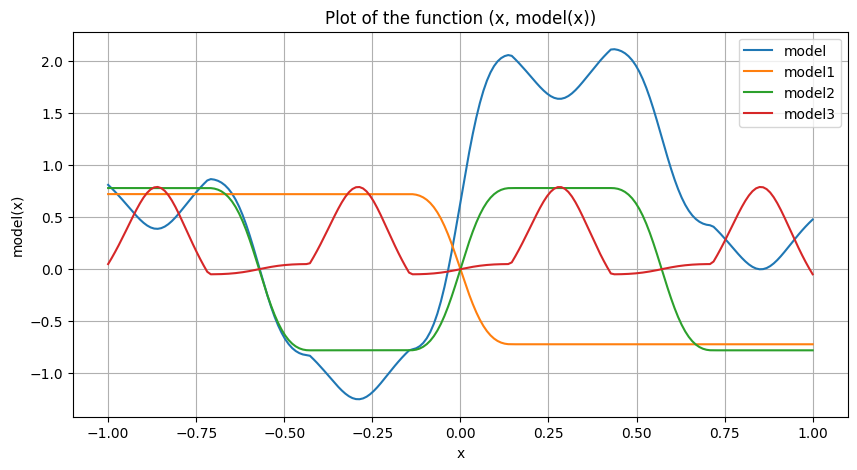

In [177]:
import torch
import matplotlib.pyplot as plt

a = 1
x_values = torch.linspace(-a, a, steps=200, dtype=torch.float64).unsqueeze(
    1
)
with torch.no_grad():
    y_values = model(x_values)
    y1 = model1(x_values)
    y2 = model2(x_values)
    y3 = model3(x_values)

# Convert to numpy for plotting
x_values_np = x_values.numpy()
y_values_np = y_values.squeeze().numpy()
y1 = y1.squeeze().numpy()
y2 = y2.squeeze().numpy()
y3 = y3.squeeze().numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(x_values_np, y_values_np, label="model")
plt.plot(x_values_np, y1, label="model1")
plt.plot(x_values_np, y2, label="model2")
plt.plot(x_values_np, y3, label="model3")
plt.xlabel("x")
plt.ylabel("model(x)")
plt.title("Plot of the function (x, model(x))")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
a = 0.3
b = 0.5
import numpy as np


def lambda1(beta1, beta2):
    nom = (b - a) * (beta1 - beta2)
    denom = (b - a - 1) * beta2 - (b - a) * beta1

    return nom / denom


def lambda2(beta1, beta2):
    nom = (b - a - 1) * (beta1 - beta2)
    denom = (b - a - 1) * beta2 - (b - a) * beta1

    return nom / denom


def effbeta(beta1, beta2):
    lam1 = lambda1(beta1, beta2)
    lam2 = lambda2(beta1, beta2)

    beta = beta1 * (lam1 + 1) * (1 + a - b) + beta2 * (b - a) * (lam2 + 1)
    # beta = np.cos(beta1) + np.sin(beta2)
    return beta

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.01, 1000, 100)
beta2_range = np.linspace(0.01, 1000, 100)
beta1, beta2 = np.meshgrid(beta1_range, beta2_range)

# Compute effbeta for each combination of beta1 and beta2
eff_beta_values = effbeta(beta1, beta2)

# Create a heat plot
plt.figure(figsize=(10, 8))
plt.imshow(
    eff_beta_values,
    extent=(0.05, 400, 0.05, 400),
    origin="lower",
    aspect="auto",
)
plt.colorbar(label="effbeta")
plt.xlabel("beta1")
plt.ylabel("beta2")
plt.title("Heat Plot of effbeta")
plt.show()

# Create a surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(beta1, beta2, eff_beta_values, cmap="viridis")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel("beta1")
ax.set_ylabel("beta2")
ax.set_zlabel("effbeta")
ax.set_title("Surface Plot of effbeta")
plt.show()

In [ ]:
from qulearn.qlayer import CircuitLayer
import pennylane as qml


class QFTLayer(CircuitLayer):
    def __init__(self, wires) -> None:
        super().__init__(wires)

    def circuit(self, _):
        qml.QFT(wires=self.wires)


class RYLayer(CircuitLayer):
    def __init__(self, wires) -> None:
        super().__init__(wires)

    def circuit(self, x):
        for xj, w in zip(x, self.wires):
            qml.RY(xj, w)

In [ ]:
import pennylane as qml
from qulearn.qlayer import (
    AltRotCXLayer,
    ParallelEntangledIQPEncoding,
    ParallelIQPEncoding,
    MeasurementLayer,
    MeasurementType,
    IQPERYCZLayer,
    RYCZLayer,
    IQPEAltRotCXLayer,
    HadamardLayer,
    HamiltonianLayer,
    IQPEmbeddingLayer,
    AltRXCXLayer,
)
from qulearn.qkernel import QKernel
from qulearn.trainer import RidgeRegression
import torch
from torch.nn import MSELoss
import logging
from torch.utils.data import DataLoader, TensorDataset

num_features = 2
num_feature_repeat = 2
wires = num_features * num_feature_repeat
embed = ParallelIQPEncoding(
    wires, num_features=num_features, base=3.0, omega=1.0, n_repeat=1
)
hads = HadamardLayer(wires=wires)
var1 = AltRotCXLayer(wires=wires, n_layers=0)
var2 = AltRotCXLayer(wires=wires, n_layers=0)
var3 = AltRotCXLayer(wires=wires, n_layers=0)
obs = [qml.PauliZ(j) for j in range(wires)]

qdevice = qml.device("default.qubit", wires=wires, shots=None)
interface = "torch"
diff_method = "backprop"

model = MeasurementLayer(
    var1,
    embed,
    var2,
    embed,
    var3,
    observables=obs,
    measurement_type=MeasurementType.Expectation,
)
drawer = qml.draw(model.qnode, show_all_wires=True, expansion_strategy="device")
x = 2 * torch.rand(10, num_features) - 1
print(drawer(x))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(qml.specs(model.qnode)(x))

print("x =", x.shape)
y = model(x)
print("y =", y.shape)

In [ ]:
import torch
import torch.nn as nn
import itertools


class ClassicalSurrogate2(nn.Module):
    def __init__(self, num_features, max_frequency):
        super(ClassicalSurrogate2, self).__init__()

        self.num_features = num_features
        self.max_frequency = max_frequency
        self.frequency_range = list(range(-max_frequency, max_frequency + 1))
        self.num_omegas = len(self.frequency_range) ** num_features

        self.alpha = nn.Parameter(
            torch.empty(self.num_omegas, dtype=torch.float64)
        )
        self.beta = nn.Parameter(
            torch.empty(self.num_omegas, dtype=torch.float64)
        )
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)

        # Assume z_function is identity by default, can be replaced with any transformation
        self.z_function = lambda x: x

    def forward(self, x):
        z_x = self.z_function(x)
        outputs = torch.zeros(x.size(0), dtype=torch.float64)

        index = 0
        for omega in itertools.product(
            self.frequency_range, repeat=self.num_features
        ):
            omega = torch.tensor(omega, dtype=torch.float64)

            # Compute dot product
            dot_product = torch.matmul(z_x, omega)

            # Compute cosine and sine values
            cos_value = torch.cos(dot_product)
            sin_value = torch.sin(dot_product)

            # Weighted sum of cosine and sine values for each sample
            outputs += (
                self.alpha[index] * cos_value + self.beta[index] * sin_value
            )
            index += 1

        return outputs.unsqueeze(1)

    def fit_fourier_coefficients(self, X, Y):
        with torch.no_grad():
            z_x = self.z_function(X)
            features_cos = []
            features_sin = []

            for omega in itertools.product(
                self.frequency_range, repeat=self.num_features
            ):
                omega = torch.tensor(omega, dtype=torch.float64)

                # Compute dot product
                dot_product = torch.matmul(z_x, omega)

                # Compute cosine and sine values
                features_cos.append(torch.cos(dot_product))
                features_sin.append(torch.sin(dot_product))

            # Stack features
            features = torch.cat(
                [torch.stack(features_cos).t(), torch.stack(features_sin).t()],
                dim=1,
            )

            # Solve the least squares problem A*c = b
            coefficients = torch.linalg.lstsq(
                features, Y, driver="gelsd"
            ).solution.squeeze()

            # Update the parameters with the new coefficients
            self.alpha.data = coefficients[: self.num_omegas]
            self.beta.data = coefficients[self.num_omegas :]

In [ ]:
import torch
import torch.nn as nn
import itertools


class ClassicalSurrogate(nn.Module):
    def __init__(self, num_features, max_frequency):
        super(ClassicalSurrogate, self).__init__()

        # Create the omega spectrum using all combinations of frequencies for each feature dimension
        frequency_range = range(-max_frequency, max_frequency + 1)
        omega_spectrum = list(
            itertools.product(frequency_range, repeat=num_features)
        )
        self.omegas = torch.tensor(omega_spectrum, dtype=torch.float64)

        self.alpha = nn.Parameter(
            torch.empty(len(omega_spectrum), dtype=torch.float64)
        )
        self.beta = nn.Parameter(
            torch.empty(len(omega_spectrum), dtype=torch.float64)
        )
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)

        # Assume z_function is identity by default, can be replaced with any transformation
        self.z_function = lambda x: x

    def forward(self, x):
        z_x = self.z_function(x)

        # Compute dot product
        dot_products = torch.mm(z_x, self.omegas.t())

        # Compute cosine and sine values
        cos_values = torch.cos(dot_products)
        sin_values = torch.sin(dot_products)

        # Weighted sum of cosine and sine values for each sample
        outputs = torch.sum(
            self.alpha.squeeze() * cos_values
            + self.beta.squeeze() * sin_values,
            dim=1,
        )
        return outputs.unsqueeze(1)

    def fit_fourier_coefficients(self, X, Y):
        with torch.no_grad():
            # Compute the feature vectors for the dataset
            z_x = self.z_function(X)
            dot_products = torch.mm(z_x, self.omegas.t())
            cos_values = torch.cos(dot_products)
            sin_values = torch.sin(dot_products)

            # Stack features and add a column for the bias term
            features = torch.cat([cos_values, sin_values], dim=1)

            # Solve the least squares problem A*c = b
            coefficients = torch.linalg.lstsq(
                features, Y, driver="gelsd"
            ).solution.squeeze()

            # Update the parameters with the new coefficients
            self.alpha.data = coefficients[: self.omegas.size(0)]
            self.beta.data = coefficients[self.omegas.size(0) :]


# Example usage:
def id_z(x):
    # For demonstration, we're returning x. Replace this with any required transformation.
    return x


# Assuming z(x) is a 3-dimensional vector, and each component can take values [1.0, 2.0] or [2.0, 3.0] or [1.0, 3.0]
max_frequency = 3
num_features = 2
model = ClassicalSurrogate(
    num_features=num_features, max_frequency=max_frequency
)

# Example forward pass:
x = torch.randn((1, num_features), dtype=torch.float64)
output = model(x)
print(output)
print(output.shape)

In [ ]:
from torch import nn
import torch.nn.functional as F
import torch
import pennylane as qml
from qulearn.qlayer import (
    AltRotCXLayer,
    ParallelIQPEncoding,
    MeasurementLayer,
    MeasurementType,
    HamiltonianLayer,
)


class LeakyReLUNet(nn.Module):
    def __init__(self, num_features, dim=64):
        super(LeakyReLUNet, self).__init__()

        self.fc1 = nn.Linear(num_features, dim, dtype=torch.float64)
        self.fc2 = nn.Linear(dim, dim, dtype=torch.float64)
        self.fc3 = nn.Linear(dim, 1, dtype=torch.float64)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)


class QNN(nn.Module):
    def __init__(self, num_wires, num_features, n_layers=2):
        super().__init__()

        var0 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        embed = ParallelIQPEncoding(
            num_wires,
            num_features=num_features,
            base=3.0,
            omega=1.0,
            n_repeat=1,
        )
        var1 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        obs = [qml.PauliZ(j) for j in range(num_wires)]

        qdev = qml.device(wires=num_wires, name="lightning.qubit")
        diff_method = "adjoint"
        self.qnn = MeasurementLayer(
            var0,
            embed,
            var1,
            observables=obs,
            measurement_type=MeasurementType.Expectation,
            qdevice=qdev,
            diff_method=diff_method,
        )

    def forward(self, x):
        tmp = self.qnn(x)
        return tmp


class QNN2(nn.Module):
    def __init__(self, num_wires, num_features, n_layers=2):
        super().__init__()

        var0 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        embed = ParallelIQPEncoding(
            num_wires,
            num_features=num_features,
            base=3.0,
            omega=1.0,
            n_repeat=1,
        )
        var1 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        obs = [qml.Identity(0), qml.PauliZ(0)]

        qdev = qml.device(wires=num_wires, name="lightning.qubit")
        diff_method = "adjoint"
        self.qnn = HamiltonianLayer(
            var0,
            embed,
            var1,
            observables=obs,
            qdevice=qdev,
            diff_method=diff_method,
        )

    def forward(self, x):
        tmp = self.qnn(x)
        return tmp


class QNN3(nn.Module):
    def __init__(self, num_wires, num_features, n_layers=2):
        super().__init__()

        var0 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        embed = ParallelIQPEncoding(
            num_wires,
            num_features=num_features,
            base=3.0,
            omega=1.0,
            n_repeat=1,
        )
        var1 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        self.qnn = MeasurementLayer(
            var0, embed, var1, measurement_type=MeasurementType.Probabilities
        )

    def forward(self, x):
        tmp = self.qnn(x)
        return tmp


class QNN4(nn.Module):
    def __init__(self, num_wires, num_features, n_layers=2):
        super().__init__()

        var0 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        embed = ParallelIQPEncoding(
            num_wires,
            num_features=num_features,
            base=3.0,
            omega=1.0,
            n_repeat=1,
        )
        var1 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        obs = [qml.PauliZ(j) for j in range(num_wires)]

        qdev = qml.device(wires=num_wires, name="lightning.qubit")
        diff_method = "adjoint"
        self.qnn = MeasurementLayer(
            var0,
            embed,
            var1,
            observables=obs,
            measurement_type=MeasurementType.Expectation,
            qdevice=qdev,
            diff_method=diff_method,
        )

    def forward(self, x):
        tmp = self.qnn(x)
        return tmp


class QNN5(nn.Module):
    def __init__(self, num_wires, n_layers=2):
        super().__init__()

        var0 = AltRotCXLayer(wires=num_wires, n_layers=n_layers)
        obs = [qml.PauliZ(j) for j in range(num_wires)]

        qdev = qml.device(wires=num_wires, name="lightning.qubit")
        diff_method = "adjoint"
        self.qnn = MeasurementLayer(
            var0,
            observables=obs,
            measurement_type=MeasurementType.Expectation,
            qdevice=qdev,
            diff_method=diff_method,
        )

    def forward(self, x):
        tmp = self.qnn(x)
        return tmp


class Hybrid(nn.Module):
    def __init__(self, num_wires, num_features, relu_dim=64, n_layers=2):
        super().__init__()

        self.qnn = QNN(num_wires, num_features, n_layers)
        self.lrelu = LeakyReLUNet(
            num_features=num_wires + num_features, dim=relu_dim
        )

    def forward(self, x):
        # tmp = torch.arccos(x)
        tmp = 2.0 * torch.pi * torch.sigmoid(x) - torch.pi
        # tmp = 2.0*torch.atan(x)
        # tmp = x
        tmp = self.qnn(tmp)
        tmp = torch.cat((tmp, x), dim=-1)
        tmp = self.lrelu(tmp)
        return tmp


num_features = 2
num_repeat = 3
num_layers = 2
relu_dim = 64
num_wires = num_features * num_repeat

relu = LeakyReLUNet(num_features, relu_dim)
qnn = QNN(num_wires, num_features, num_layers)
qnn2 = QNN2(num_wires, num_features, num_layers)
qnn3 = QNN3(num_wires, num_features, num_layers)
qnn5 = QNN5(num_wires, num_layers)
hybrid = Hybrid(num_wires, num_features, relu_dim)
x = torch.randn((10, num_features), dtype=torch.float64)
print("x =", x.shape)
y = qnn2(x)
print("y =", y.shape)
# tmp = torch.mm(y.t(), y)
# print(tmp)
# tmp.backward()

In [ ]:
x = torch.randn((num_features), dtype=torch.float64)
print(x.shape)
x = x.unsqueeze(-1)
print(x.shape)
x = x.squeeze(-1)
print(x.shape)

In [ ]:
import torch
import torch.optim as optim

# Assuming `model` is your pre-defined model
# Assume `x` is a tensor representing your input variable, initialized at some value

# Define the objective function
a = torch.pi
model = qnn
x = torch.linspace(-a, a, steps=100, dtype=torch.float64).unsqueeze(1)


def compute_variation(Y):
    differences = Y[1:] - Y[:-1]

    # Square the differences
    squared_differences = differences**2

    # Sum the squared differences
    variation = torch.sum(squared_differences)

    return variation


def lossfn(x, model, component_indices):
    # Forward pass to get the feature vector
    feature_vector = model(x)

    # Select the components to analyze
    component1 = feature_vector[:, component_indices[0]]
    component2 = feature_vector[:, component_indices[1]]

    # Compute the variation (gradient) of each component w.r.t x and its magnitude
    var1 = compute_variation(component1)
    var2 = compute_variation(component2)

    # Compute the difference in magnitudes of variations
    loss = -var1 + var2

    # Minimize the absolute difference in magnitudes of variations
    return loss


# Select indices of components to compare
component_indices = [1, 2]  # Replace with your chosen indices

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Optimization loop
for step in range(30):  # Number of optimization steps
    optimizer.zero_grad()
    loss = lossfn(x, model, component_indices)
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item()}")

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming `model` is already defined and has a method `forward` that can be called with a torch tensor.
# Replace 'model' with your actual model variable.

# Define the range for x
model = hybrid
a = torch.pi
# a = 5
# a = 1
x_values = torch.linspace(-a, a, steps=200, dtype=torch.float64).unsqueeze(
    1
)  # Replace -10 and 10 with your range of x values.

# Calculate model predictions
with torch.no_grad():  # We do not need to track gradients for this operation
    y_values = model(x_values)
    # y_values = 2.0*torch.pi*torch.sigmoid(x_values.unsqueeze(1))-torch.pi
    # y_values = torch.sigmoid(x_values.unsqueeze(1))
    # y_values1 = model(x_values.unsqueeze(1))[:, 0]
    # y_values2 = model(x_values.unsqueeze(1))[:, 1]
    # y_values3 = model(x_values.unsqueeze(1))[:, 2]
    # y_values_arcsin = torch.arctan(y_values)
    # y_values_arcsin = torch.zeros(len(y_values))

# Convert to numpy for plotting
x_values_np = x_values.numpy()
y_values_np = y_values.squeeze().numpy()
# y_values_np1 = y_values1.squeeze().numpy()
# y_values_np2 = y_values2.squeeze().numpy()
# y_values_np3 = y_values3.squeeze().numpy()
# y_values_np_arcsin = y_values_arcsin.squeeze().numpy()

# Plotting
for k in range(1):
    plt.figure(figsize=(10, 5))
    plt.plot(x_values_np, y_values_np, label="model")
    # plt.plot(x_values_np, y_values_np1, label='Z_0')
    # plt.plot(x_values_np, y_values_np2, label='Z_1')
    # plt.plot(x_values_np, y_values_np3, label='Z_2')
    plt.xlabel("x")
    plt.ylabel("model(x)")
    plt.title("Plot of the function (x, model(x))")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Fetch the California housing dataset
california_housing = fetch_california_housing()
X, Y = california_housing.data, california_housing.target

# Rescale the features to the range [-pi, pi]
scaler = MinMaxScaler(feature_range=(-np.pi, np.pi))
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).view(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).view(-1, 1)

In [ ]:
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate samples using Latin Hypercube Sampling
n_train = 500  # Number of samples
n_valid = 100
lower_bounds = np.array([10, 10])
upper_bounds = np.array([300, 300])
X_train = lhs(2, samples=n_train)
X_train = lower_bounds + (upper_bounds - lower_bounds) * X_train

lower_bounds = np.array([0.01, 0.01])
upper_bounds = np.array([700, 700])
X_valid = lhs(2, samples=n_valid)
X_valid = lower_bounds + (upper_bounds - lower_bounds) * X_valid

# Evaluate the function at each sample point and add Gaussian noise
Y_train = np.array([effbeta(sample[0], sample[1]) for sample in X_train])
sigma = 0.001
noise = np.random.normal(0, sigma, Y_train.shape)
Y_train = Y_train + noise

Y_valid = np.array([effbeta(sample[0], sample[1]) for sample in X_valid])

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap="viridis")
plt.colorbar(sc)
plt.xlabel("Beta 1")
plt.ylabel("Beta 2")
plt.title("2D Scatter Heat Map")
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    X_train[:, 0], X_train[:, 1], Y_train, c=Y_train, cmap="viridis"
)
plt.colorbar(sc)
ax.set_xlabel("Beta 1")
ax.set_ylabel("Beta 2")
ax.set_zlabel("Effbeta")
plt.title("3D Scatter Plot")
plt.show()

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_valid[:, 0], X_valid[:, 1], c=Y_valid, cmap="viridis")
plt.colorbar(sc)
plt.xlabel("Beta 1")
plt.ylabel("Beta 2")
plt.title("2D Scatter Heat Map")
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    X_valid[:, 0], X_valid[:, 1], Y_valid, c=Y_valid, cmap="viridis"
)
plt.colorbar(sc)
ax.set_xlabel("Beta 1")
ax.set_ylabel("Beta 2")
ax.set_zlabel("Effbeta")
plt.title("3D Scatter Plot")
plt.show()

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).view(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).view(-1, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Rescale the features to the range [-pi, pi]
scaler_input = MinMaxScaler(feature_range=(-2, 2))
scaler_output = MinMaxScaler(feature_range=(-2, 2))
scaler_input.fit(X_train)
scaler_output.fit(Y_train)
X_train = scaler_input.transform(X_train)
X_valid = scaler_input.transform(X_valid)
Y_train = scaler_output.transform(Y_train)
Y_valid = scaler_output.transform(Y_valid)

# plots
# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap="viridis")
plt.colorbar(sc)
plt.xlabel("Beta 1")
plt.ylabel("Beta 2")
plt.title("2D Scatter Heat Map")
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    X_train[:, 0], X_train[:, 1], Y_train, c=Y_train, cmap="viridis"
)
plt.colorbar(sc)
ax.set_xlabel("Beta 1")
ax.set_ylabel("Beta 2")
ax.set_zlabel("Effbeta")
plt.title("3D Scatter Plot")
plt.show()

# 2D Scatter Heat Map
plt.figure(figsize=(8, 6))
sc = plt.scatter(X_valid[:, 0], X_valid[:, 1], c=Y_valid, cmap="viridis")
plt.colorbar(sc)
plt.xlabel("Beta 1")
plt.ylabel("Beta 2")
plt.title("2D Scatter Heat Map")
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(
    X_valid[:, 0], X_valid[:, 1], Y_valid, c=Y_valid, cmap="viridis"
)
plt.colorbar(sc)
ax.set_xlabel("Beta 1")
ax.set_ylabel("Beta 2")
ax.set_zlabel("Effbeta")
plt.title("3D Scatter Plot")
plt.show()

# Convert arrays to tensors
X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).view(-1, 1)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).view(-1, 1)

In [ ]:
import torch
import logging
from torch.optim import Adam, LBFGS
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset

# Data
X_train = torch.tensor(X_train, dtype=torch.float64)
X_valid = torch.tensor(X_valid, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).unsqueeze(1)
Y_valid = torch.tensor(Y_valid, dtype=torch.float64).unsqueeze(1)

In [178]:
import torch

# Generate a sample of inputs
X = torch.linspace(-1, 1, 1000).reshape(-1, 1)


# Define a function to add Gaussian noise
def add_gaussian_noise(tensor, mean=0.0, std=0.01):
    return tensor + torch.randn(tensor.size()) * std + mean


# 1. Linear Relationship
def linear(X, m=2, c=3):
    return m * X + c


Y_linear = add_gaussian_noise(linear(X))


# 2. Polynomial Relationship (Quadratic for demonstration)
def polynomial(X, a=3, b=2, c=-5):
    return a * X**2 + b * X + c


Y_polynomial = add_gaussian_noise(polynomial(X))


# 3. Exponential Relationship
def exponential(X, a=2, b=0.5):
    return a * torch.exp(b * X)


Y_exponential = add_gaussian_noise(exponential(X))


# 4. Logarithmic Relationship
def logarithmic(X, a=3, b=2):
    return a * torch.log(X) + b


Y_logarithmic = add_gaussian_noise(logarithmic(X))


# 5. Trigonometric Relationship
def trigonometric(X, a=5, b=2, c=0.5):
    return a * torch.sin(b * X + c)


Y_trigonometric = add_gaussian_noise(trigonometric(X))


# 6. Power-law Relationship
def power_law(X, a=2, b=1.5):
    return a * X**b


Y_power_law = add_gaussian_noise(power_law(X))


# 7. Sigmoidal Relationship
def sigmoidal(X, L=1, k=0.5, x0=5):
    return L / (1 + torch.exp(-k * (X - x0)))


Y_sigmoidal = add_gaussian_noise(sigmoidal(X))


# 8. Gaussian Relationship
def gaussian(X, a=1.0, b=0, c=1):
    return a * torch.exp(-((X - b) ** 2) / (2 * c**2))


Y_gaussian = add_gaussian_noise(gaussian(X))


# 9. Step Function
def step_function(
    X, threshold1=-0.5, threshold2=0.5, low_value=-1, mid_value=1, high_value=0
):
    condition1 = X < threshold1
    condition2 = (X >= threshold1) & (X < threshold2)
    condition3 = X >= threshold2

    values = torch.zeros_like(X)
    values[condition1] = low_value
    values[condition2] = mid_value
    values[condition3] = high_value

    return values


Y_step = add_gaussian_noise(step_function(X))


def piecewise_linear_3segments(X, a=-1, b=1, m1=2, c1=0, m2=-3, m3=1):
    # Define linear functions for each segment
    linear_before_a = m1 * X + c1
    linear_between_a_b = m1 * a + c1 + m2 * (X - a)
    linear_after_b = m1 * a + c1 + m2 * (b - a) + m3 * (X - b)

    # Apply conditions for each segment
    conditions = [(X < a), (X >= a) & (X < b), (X >= b)]
    functions = [linear_before_a, linear_between_a_b, linear_after_b]

    output = torch.zeros_like(X)
    for condition, function in zip(conditions, functions):
        output[condition] = function[condition]

    return output


Y_piecewise_spiked = add_gaussian_noise(piecewise_linear_3segments(X))


def multidimstep(X, a=1.0):
    # Extract the first and second features
    X0 = X[:, 0]
    X1 = X[:, 1]

    # Check the condition X[1] > a * X[0]
    condition = X1 > a * X0

    # Initialize the output tensor Y
    Y = torch.zeros_like(X1)

    # Set Y values based on the condition
    Y[condition] = 1  # Set to +1 where condition is True
    Y[~condition] = -1  # Set to -1 where condition is False

    return Y.view(-1, 1)  # Reshape to make it a column vector


def high_low(X, low=1.0, high=30.0):
    return torch.sin(low * X) + 0.5 * torch.sin(high * X)


Y_high_low = add_gaussian_noise(high_low(X))

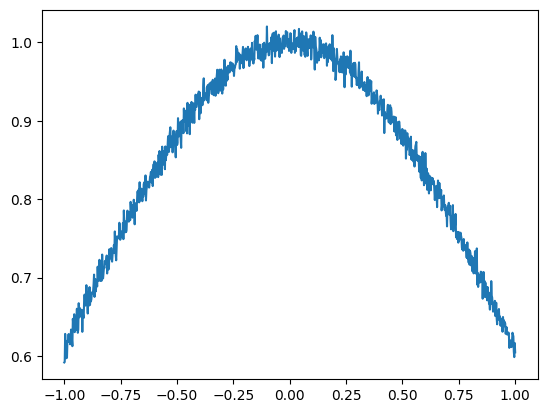

In [179]:
import matplotlib.pyplot as plt

# Create the scatter plot
func = step_function
func = gaussian
sigma = 0.01
Y = add_gaussian_noise(func(X), std=sigma)
plt.plot(X, Y)

# Show the plot
plt.show()

In [180]:
import torch
import logging
from torch.optim import Adam
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset

# Data
N_train = 100
N_valid = 5
batch_size = 25
X_train = torch.linspace(-1, 1, N_train, dtype=torch.float64).reshape(-1, 1)
Y_train = add_gaussian_noise(func(X_train), std=sigma)
X_valid = torch.linspace(-1, 1, N_valid, dtype=torch.float64).reshape(-1, 1)
Y_valid = func(X_valid)
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=False)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=False)

In [ ]:
model = relu
y = model(X_train)
print(y.shape)
model = qnn
y = model(X_train)
print(y.shape)
model = qnn2
y = model(X_train)
print(y.shape)
model = hybrid
y = model(X_train)
print(y.shape)

In [ ]:
import torch
import logging
from torch.optim import Adam, LBFGS
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.regression import MeanAbsolutePercentageError

batch_size = 50
data_train = TensorDataset(X_train, Y_train)
data_valid = TensorDataset(X_valid, Y_valid)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(data_valid, batch_size=batch_size, shuffle=True)

In [181]:
import torch
import logging
from torch.optim import Adam, LBFGS
from qulearn.trainer import SupervisedTrainer
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.regression import MeanAbsolutePercentageError

# Trainer
lr = 0.1
#model = combined_model
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)
loss_fn = torch.nn.MSELoss()
metric = MeanAbsolutePercentageError()

In [182]:
logger = logging.getLogger("train_function")
logger.setLevel(level=logging.INFO)
num_epochs = 200
trainer = SupervisedTrainer(
    optimizer=optimizer,
    loss_fn=loss_fn,
    metrics={"MARE": metric},
    num_epochs=num_epochs,
    logger=logger,
)

In [183]:
# Train
trainer.train(model, train_data=loader_train, valid_data=loader_valid)

INFO:train_function:Train - Epoch: 1, Loss: 0.748526, Metrics: MARE: 0.779388
INFO:train_function:Validate - Epoch: 1, Loss: 0.471923, Metrics: MARE: 0.732617
INFO:train_function:Train - Epoch: 2, Loss: 0.330638, Metrics: MARE: 0.500763
INFO:train_function:Validate - Epoch: 2, Loss: 0.199134, Metrics: MARE: 0.512214
INFO:train_function:Train - Epoch: 3, Loss: 0.108261, Metrics: MARE: 0.311547
INFO:train_function:Validate - Epoch: 3, Loss: 0.068448, Metrics: MARE: 0.300680
INFO:train_function:Train - Epoch: 4, Loss: 0.075707, Metrics: MARE: 0.248871
INFO:train_function:Validate - Epoch: 4, Loss: 0.059307, Metrics: MARE: 0.204016
INFO:train_function:Train - Epoch: 5, Loss: 0.107496, Metrics: MARE: 0.256872
INFO:train_function:Validate - Epoch: 5, Loss: 0.084355, Metrics: MARE: 0.254385
INFO:train_function:Train - Epoch: 6, Loss: 0.108931, Metrics: MARE: 0.272904
INFO:train_function:Validate - Epoch: 6, Loss: 0.087002, Metrics: MARE: 0.279545
INFO:train_function:Train - Epoch: 7, Loss: 0.

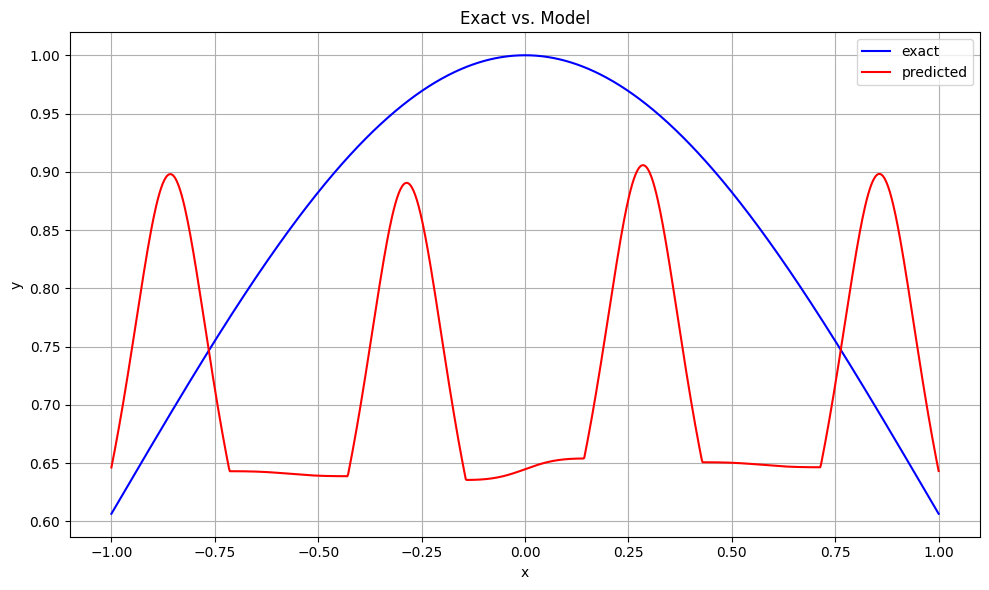

In [184]:
# Plotting
X = torch.linspace(-1, 1, 1000, dtype=torch.float64).reshape(-1, 1)
Y_exact = func(X)
model.eval()
with torch.no_grad():
    Y_model = model(X)
plt.figure(figsize=(10, 6))
plt.plot(X, Y_exact, label="exact", color="blue")
plt.plot(X, Y_model, label="predicted", color="red")

# Adding title and labels
plt.title("Exact vs. Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from torchmetrics.regression import MeanAbsolutePercentageError

predicted_train = model(X_train)
predicted_valid = model(X_valid)

metric = MeanAbsolutePercentageError()
loss_train = metric(predicted_train, Y_train)
loss_valid = metric(predicted_valid, Y_valid)
print("train loss: ", loss_train)
print("valid_loss: ", loss_valid)

In [ ]:
from torchmetrics.regression import MeanAbsolutePercentageError

model.fit_fourier_coefficients(X_train, Y_train)

In [ ]:
predicted_train = model(X_train)
predicted_valid = model(X_valid)

metric = MeanAbsolutePercentageError()
metric = torch.nn.MSELoss()
loss_train = metric(predicted_train, Y_train)
loss_valid = metric(predicted_valid, Y_valid)
print("train loss: ", loss_train)
print("valid_loss: ", loss_valid)

model = ClassicalSurrogate(id_z, all_combinations)

print(model.omegas)
alphas = np.zeros(9)
betas = np.zeros(9)
alphas[8] = 1.0
betas[5] = 1
#model.alpha.data = torch.tensor(alphas)
#model.beta.data = torch.tensor(betas)

grid_size = 10
x = np.linspace(1, 2, grid_size)
y = np.linspace(1, 2, grid_size)
X_train = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
Y_train = np.sin(X_train[:, 1])

X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64).unsqueeze(1)

predicted = model(X_train)
loss = loss_fn(predicted, Y_train)
print("Before fitting: ", loss)

model.fit_fourier_coefficients(X_train, Y_train)

predicted = model(X_train)
loss = loss_fn(predicted, Y_train)
print("After fitting: ", loss)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.01, 700, 100)
beta2_range = np.linspace(0.01, 700, 100)

beta1, beta2 = np.meshgrid(beta1_range, beta2_range)
betas = np.vstack([beta1.ravel(), beta2.ravel()]).T
betas = scaler_input.transform(betas)
betas_tensor = torch.tensor(betas, dtype=torch.float64)

# Compute effbeta for each combination of beta1 and beta2
with torch.no_grad():
    predicted = model(betas_tensor)

predicted_reshaped = predicted.reshape(beta1.shape)

# Create a surface plot
beta1_original_flat, beta2_original_flat = np.split(betas, 2, axis=1)
# Reshape back to the original meshgrid format
beta1 = beta1_original_flat.reshape(beta1.shape)
beta2 = beta2_original_flat.reshape(beta2.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(beta1, beta2, predicted_reshaped, cmap="viridis")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel("beta1")
ax.set_ylabel("beta2")
ax.set_zlabel("effbeta")
ax.set_title("Surface Plot of effbeta")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the range of beta1 and beta2 values
beta1_range = np.linspace(0.05, 400, 100)
beta2_range = np.linspace(0.05, 400, 100)
beta1, beta2 = np.meshgrid(beta1_range, beta2_range)

exact = effbeta(beta1, beta2)
exact_flat = exact.ravel().reshape(-1, 1)
exact_scaled_flat = scaler_output.transform(exact_flat)
exact_scaled = exact_scaled_flat.reshape(beta1.shape)

betas = np.vstack([beta1.ravel(), beta2.ravel()]).T
betas = scaler_input.transform(betas)
betas_tensor = torch.tensor(betas, dtype=torch.float64)

# Create a surface plot
beta1_original_flat, beta2_original_flat = np.split(betas, 2, axis=1)
# Reshape back to the original meshgrid format
beta1 = beta1_original_flat.reshape(beta1.shape)
beta2 = beta2_original_flat.reshape(beta2.shape)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(beta1, beta2, exact_scaled, cmap="viridis")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel("beta1")
ax.set_ylabel("beta2")
ax.set_zlabel("effbeta")
ax.set_title("Surface Plot of effbeta")
plt.show()